In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from scipy import interpolate

In [26]:
#let's consider the atmoshperic parameters for our target:
# (random values...) 
star_teff = [5400., 161.5]
star_logg = [4.5, 0.224] 
star_gfeh = [0.06, 0.108] 


# this time we take 2 values for gravity, the closest to our actual input value 
# one from above, one from below

# Claret 2017 - selection by gravity

In [27]:
#!form=a
#${logg} ${Teff} ${Z} ${xi} ${aLSM} ${bLSM} ${aPCM} ${bPCM} ${chi2} ${Mod}
# (hit Return)
## (from tabmap V6.0 (2016-08-18)) 2020-12-08T20:14:03
#---------------------------------------------------------------------------
#-- J/A+A/600/A30 Limb-darkening for TESS satellite (Claret, 2017)
#--------------------------------------------------------------------------
#---Table: J/A+A/600/A30/table25.dat.gz a, b quadratic LDCs, ATLAS models, all metallicities, v.tu=0,1,2,4,8 km/s for TESS (LSM, PCM)  (9586 records)
#-------------------------------------------------------------------------------
#     Label Format Unit    Explanations
#-------------------------------------------------------------------------------
#      logg F5.2   [cm/s2] [0.0/5.0] Surface gravity
#      Teff F6.0   K       [3500/50000] Effective temperature
#         Z F4.1   [Sun]   [-5.0/1.0] Metallicity (log[M/H])
#        xi F3.1   km/s    [0/8] Microturbulent velocity {xi}
#      aLSM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS LSM) (G2)
#      bLSM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS LSM) (G2)
#      aPCM F8.4   ---     Quadratic limb darkening coefficient a
#                           (TESS FCM) (G2)
#      bPCM F8.4   ---     Quadratic limb darkening coefficient b
#                           (TESS FCM) (G2)
#      chi2 F6.4   ---     SQRT(CHI2Q) (TESS LSM)
#       Mod A2     ---     [PD PC A] Model name (G3)
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------
#table15 = np.genfromtxt('table15_claret2017.dat',dtype=np.double)


# first we take two tables for two gravity values, the two closest to the actual value of or star, in the upper limit and lower limit. 

table25 = np.genfromtxt('Claret2017_table25.dat',dtype=np.double)

delta_loggv1 = star_logg[0] - 0.25
delta_loggv2 = star_logg[0] + 0.25

# we use 0.25 because it's half a step of the list of gravity values

# pick the closest value to gravity - lower side
loggv1_ind = np.argmin(np.abs(table25[:,0]-delta_loggv1))
print('Selected first  gravity value from the table: ', table25[loggv1_ind,0])
loggv1_sel = (table25[:,0] == table25[loggv1_ind,0]) & (table25[:,3] == 2.0) 
# we also select microturbulence == 2.0

# pick the closest value to gravity - upper side
loggv2_ind = np.argmin(np.abs(table25[:,0]-delta_loggv2))
print('Selected second gravity value from the table: ', table25[loggv2_ind,0])
loggv2_sel = (table25[:,0] == table25[loggv2_ind,0]) & (table25[:,3] == 2.0) 


teff_loggv1 = table25[loggv1_sel,1]
gfeh_loggv1 = table25[loggv1_sel,2]
ld_c1_loggv1 = table25[loggv1_sel,4]
ld_c2_loggv1 = table25[loggv1_sel,5]

teff_loggv2 = table25[loggv2_sel,1]
gfeh_loggv2 = table25[loggv2_sel,2]
ld_c1_loggv2 = table25[loggv2_sel,4]
ld_c2_loggv2 = table25[loggv2_sel,5]

# let's print a bunch of numbers
print('gfeh: ',gfeh_loggv1[:10])
print('Teff: ',teff_loggv1[:10])
print('LD c1:',ld_c1_loggv1[:10])
print('LD c2:',ld_c2_loggv1[:10])

print()
print('gfeh # values: ',len(gfeh_loggv1[teff_loggv1==6000.]))
print('teff # values: ',len(teff_loggv1[gfeh_loggv1==0.0]))
print('array size: ',len(gfeh_loggv1))
print('{0:.0f} x {1:.0f} = {2:.0f}'.format(len(gfeh_loggv1[teff_loggv1==6000.]), len(teff_loggv1[gfeh_loggv1==0.0]), len(gfeh_loggv1)))

print()
print('gfeh # values: ',len(gfeh_loggv2[teff_loggv2==6000.]))
print('teff # values: ',len(teff_loggv2[gfeh_loggv2==0.0]))
print('array size: ',len(gfeh_loggv2))
print('{0:.0f} x {1:.0f} = {2:.0f}'.format(len(gfeh_loggv2[teff_loggv2==6000.]), len(teff_loggv2[gfeh_loggv2==0.0]), len(gfeh_loggv2)))


# We have three columns that we have to convert to a 2D grid - x, y ,z 
# Fortunately, the file is well formatted - we have a total of 8 values 
# for log(g) for each of 72 values for temperature

# 2.50  2300.  0.0  2.0   0.3720   0.5002   0.1220   0.1678 PC TESS
# 3.00  2300.  0.0  2.0   0.3825   0.4852   0.0849   0.1785 PC TESS
# 3.50  2300.  0.0  2.0   0.4348   0.4310   0.0663   0.1413 PC TESS
# 4.00  2300.  0.0  2.0   0.4840   0.3958   0.0502   0.1122 PC TESS

print()

# avoid extreme gravities and temperatures
sel_gfeh = (teff_loggv1==6000) & (gfeh_loggv1 > -1.5)
sel_teff = (gfeh_loggv1==0.0) & (teff_loggv1 < 9500.0)

gfeh_array_logg = gfeh_loggv1[sel_gfeh]
print('gfeh coordinates (array): ',gfeh_array_logg)
teff_array_logg = teff_loggv1[sel_teff]
print('Teff coordinates (array): ',teff_array_logg)



Selected first  gravity value from the table:  4.0
Selected second gravity value from the table:  4.5
gfeh:  [-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
Teff:  [4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250. 6500.]
LD c1: [-0.0065  0.0326  0.1062  0.1722  0.1939  0.1998  0.2111  0.2194  0.2196
  0.2177]
LD c2: [0.4091 0.4183 0.3961 0.3557 0.34   0.33   0.3157 0.3026 0.2957 0.2904]

gfeh # values:  19
teff # values:  65
array size:  1037
19 x 65 = 1037

gfeh # values:  19
teff # values:  75
array size:  1083
19 x 75 = 1083

gfeh coordinates (array):  [-1.  -0.5 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.5  1. ]
Teff coordinates (array):  [3500. 3750. 4000. 4250. 4500. 4750. 5000. 5250. 5500. 5750. 6000. 6250.
 6500. 6750. 7000. 7250. 7500. 7750. 8000. 8250. 8500. 8750. 9000. 9250.]


Matrix shape:  (11, 24)


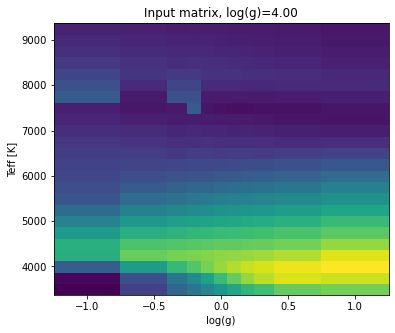

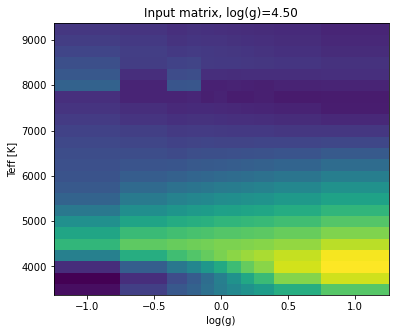

In [28]:
# we create a 2D grid with size (len(gfeh_array) x len(teff_array))
# for each LD coefficient and for each gravity value

c1_matrix_logg_v1 = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))
c2_matrix_logg_v1 = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))

c1_matrix_logg_v2 = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))
c2_matrix_logg_v2 = np.zeros((len(gfeh_array_logg), len(teff_array_logg)))


print('Matrix shape: ',np.shape(c1_matrix_logg_v1))

for gfeh_i, gfeh_v in enumerate(gfeh_array_logg):
    for teff_i, teff_v in enumerate(teff_array_logg):
        
        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (gfeh_loggv1 == gfeh_v) & (teff_loggv1 == teff_v)
        
        if np.sum(sel) == 1:
            c1_matrix_logg_v1[gfeh_i, teff_i] = ld_c1_loggv1[sel]
            c2_matrix_logg_v1[gfeh_i, teff_i] = ld_c2_loggv1[sel]
        else:
            print('No value for (gfeh,teff)=({0:f},{1:f})'.format(gfeh_v,teff_v))
            print(np.sum(sel))
            c1_matrix_logg_v1[gfeh_i, teff_i] = (c1_matrix_logg_v1[gfeh_i, teff_i-1] + c1_matrix_logg_v1[gfeh_i, teff_i+1])/2
            c2_matrix_logg_v1[gfeh_i, teff_i] = (c2_matrix_logg_v1[gfeh_i, teff_i-1] + c2_matrix_logg_v1[gfeh_i, teff_i+1])/2
            # replacing this combination with average values


        # identify the row corresponding to a given combination of gravity and tempearture 
        sel = (gfeh_loggv2 == gfeh_v) & (teff_loggv2 == teff_v)
        
        if np.sum(sel) == 1:
            c1_matrix_logg_v2[gfeh_i, teff_i] = ld_c1_loggv2[sel]
            c2_matrix_logg_v2[gfeh_i, teff_i] = ld_c2_loggv2[sel]
        else:
            print('No value for (gfeh,teff)=({0:f},{1:f})'.format(gfeh_v,teff_v))
            print(np.sum(sel))
            c1_matrix_logg_v2[gfeh_i, teff_i] = (c1_matrix_logg_v2[gfeh_i, teff_i-1] + c1_matrix_logg_v2[gfeh_i, teff_i+1])/2
            c2_matrix_logg_v2[gfeh_i, teff_i] = (c2_matrix_logg_v2[gfeh_i, teff_i-1] + c2_matrix_logg_v2[gfeh_i, teff_i+1])/2
            # replacing this combination with average values

            
            
            

# Le't see the actual matrix 
xx, yy = np.meshgrid(gfeh_array_logg,teff_array_logg)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_logg_v1.T, shading='auto')
plt.title('Input matrix, log(g)={0:4.2f}'.format(table25[loggv1_ind,0]))
plt.xlabel('[Fe/H]')
plt.ylabel('Teff [K]')
plt.show()


# Le't see the actual matrix
xx, yy = np.meshgrid(gfeh_array_logg,teff_array_logg)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_logg_v2.T, shading='auto')
plt.title('Input matrix, log(g)={0:4.2f}'.format(table25[loggv2_ind,0]))
plt.xlabel('[Fe/H]')
plt.ylabel('Teff [K]')
plt.show()

Selected first  gravity value from the table:  4.0
Selected second gravity value from the table:  4.5
Stellar gravity :  4.5


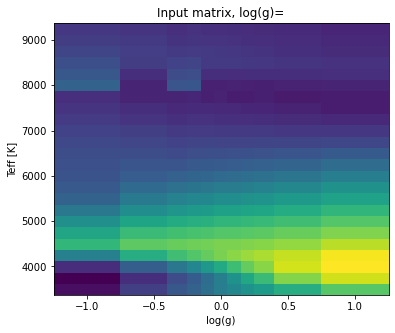

In [29]:
#Linear interpolation between the two matrix

logg_v1 = table25[loggv1_ind,0]
logg_v2 = table25[loggv2_ind,0]

print('Selected first  gravity value from the table: ', logg_v1)
print('Selected second gravity value from the table: ', logg_v2)
print('Stellar gravity : ', star_logg[0])


# y = (y0*(x1-x) + y1*(x-x0))/(x1-x0)
 
c1_matrix_logg = (c1_matrix_logg_v1 * (logg_v2-star_logg[0]) + c1_matrix_logg_v2 * (star_logg[0] - logg_v1)) / (logg_v2 - logg_v1)
c2_matrix_logg = (c2_matrix_logg_v1 * (logg_v2-star_logg[0]) + c2_matrix_logg_v2 * (star_logg[0] - logg_v1)) / (logg_v2 - logg_v1)



# Le't see the "real" matrix
xx, yy = np.meshgrid(gfeh_array_logg,teff_array_logg)
plt.figure(figsize=(6,5))
plt.pcolor(xx, yy, c1_matrix_logg_v2.T, shading='auto')
plt.title('Input matrix, log(g)=', )
plt.xlabel('[Fe/H]')
plt.ylabel('Teff [K]')
plt.show()

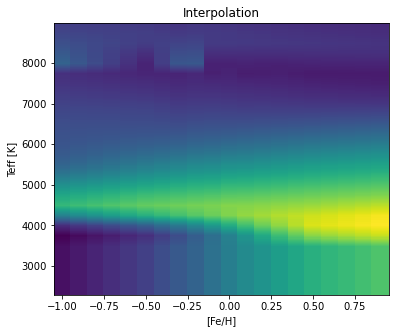

In [30]:
# bilinear_interpolation usci Scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

# Note: if len(gfeh_array)=m and len(teff_array)=n, the third array must be n*m 
c1_function_logg = interpolate.interp2d(gfeh_array_logg, teff_array_logg, c1_matrix_logg.T, kind='linear')
c2_function_logg = interpolate.interp2d(gfeh_array_logg, teff_array_logg, c2_matrix_logg.T, kind='linear')

teff_grid = np.arange(2300, 9000, 25)
gfeh_grid = np.arange(-1.0, 1.0, 0.1)

xx, yy = np.meshgrid(gfeh_grid,teff_grid)
c1_plot_out = c1_function_logg(gfeh_grid, teff_grid)

plt.figure(figsize=(6,5))
plt.pcolor(xx,yy, c1_plot_out, shading='auto')
plt.title('Interpolation')
plt.xlabel('[Fe/H]')
plt.ylabel('Teff [K]')
plt.show()

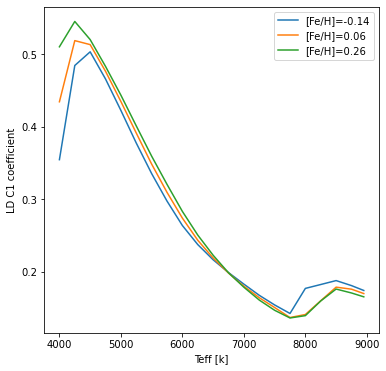

In [31]:
teff_curve = np.arange(4000,9000,50)
c1_gfeh_m02 = c1_function_logg(star_gfeh[0]-0.2, teff_curve)
c1_gfeh_val = c1_function_logg(star_gfeh[0]    , teff_curve)
c1_gfeh_p02 = c1_function_logg(star_gfeh[0]+0.2, teff_curve)
c1_gfeh_v00 = c1_function_logg(0.000, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c1_gfeh_m02, c='C0', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]-0.2))
plt.plot(teff_curve, c1_gfeh_val, c='C1', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]))
plt.plot(teff_curve, c1_gfeh_p02, c='C2', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]+0.2))
plt.ylabel('LD C1 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

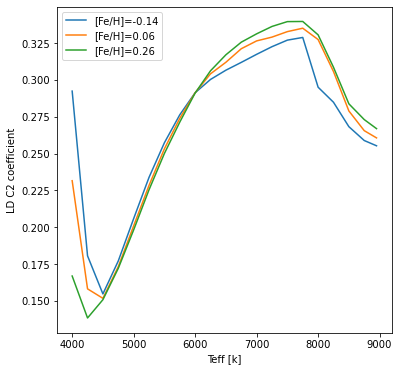

In [32]:
teff_curve = np.arange(4000,9000,50)
c2_gfeh_m02 = c2_function_logg(star_gfeh[0]-0.2, teff_curve)
c2_gfeh_val = c2_function_logg(star_gfeh[0]    , teff_curve)
c2_gfeh_p02 = c2_function_logg(star_gfeh[0]+0.2, teff_curve)

plt.figure(figsize=(6,6))
plt.plot(teff_curve, c2_gfeh_m02, c='C0', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]-0.2))
plt.plot(teff_curve, c2_gfeh_val, c='C1', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]))
plt.plot(teff_curve, c2_gfeh_p02, c='C2', linestyle='-', label='[Fe/H]={0:.2f}'.format(star_gfeh[0]+0.2))
plt.ylabel('LD C2 coefficient')
plt.xlabel('Teff [k]')
plt.legend()
plt.show()

In [33]:


teff_in = star_teff[0]
gfeh_in = star_gfeh[0]
c1_star_gfeh = c1_function_logg(gfeh_in, teff_in)[0]
c2_star_gfeh = c2_function_logg(gfeh_in, teff_in)[0]
print('Claret 2017: gfeh={0:.2f}, teff={1:.0f}, c1={2:f} c2={3:f}'.format(gfeh_in, teff_in, c1_star_gfeh, c2_star_gfeh))

Claret 2017: gfeh=0.06, teff=5400, c1=0.365388 c2=0.243256


In [22]:
# Let'r try again with a lot more of samples
n_sample = 100000  # start small (1000) and increase the number while execution time is still acceptable
teff_dist = np.random.normal(star_teff[0], star_teff[1], n_sample)
logg_dist = np.random.normal(star_logg[0], star_logg[1], n_sample)
gfeh_dist = np.random.normal(star_gfeh[0], star_gfeh[1], n_sample)

# let's do it the slow - but safe - way
c1_dist_logg = np.zeros(n_sample)
c2_dist_logg = np.zeros(n_sample)
for ii in range(0, n_sample):
    c1_dist_logg[ii] = c1_function_logg(gfeh_dist[ii], teff_dist[ii])
    c2_dist_logg[ii] = c2_function_logg(gfeh_dist[ii], teff_dist[ii])
    

number of samples: 100000   shape of the array: (100000,)



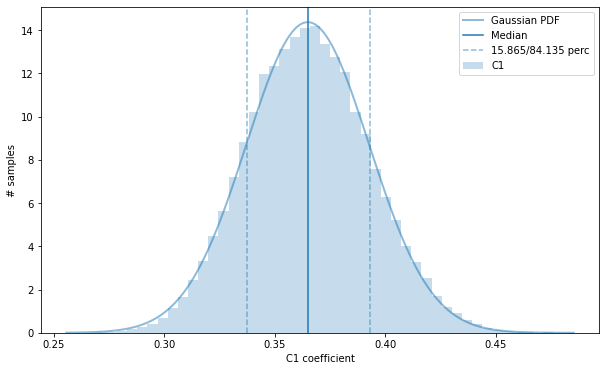

Median:   0.36493340745222974 +- 0.027760463626789078


In [36]:
print('number of samples:',len(c1_dist_logg),'  shape of the array:', c1_dist_logg.shape)

print()

c1_logg_average = np.average(c1_dist_logg) # average
c1_logg_median = np.median(c1_dist_logg)   # median
c1_logg_std = np.std(c1_dist_logg)         # standard deviation
c1_logg_minus1sigma_perc = np.percentile(c1_dist_logg, 15.865)
c1_logg_plus1sigma_perc = np.percentile(c1_dist_logg, 84.135)

# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c1_dist_logg, 50, density=True, label='C1', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c1_logg_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c1_logg_median)**2 / (2 *  c1_logg_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c1_logg_median,  c='C0', label='Median')
plt.axvline(c1_logg_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label='15.865/84.135 perc')
plt.axvline(c1_logg_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')



plt.xlabel('C1 coefficient')
plt.ylabel('# samples')
plt.legend()
plt.show()

print("Median:  ", c1_logg_median, "+-", c1_logg_std)


number of samples: 100000   shape of the array: (100000,)



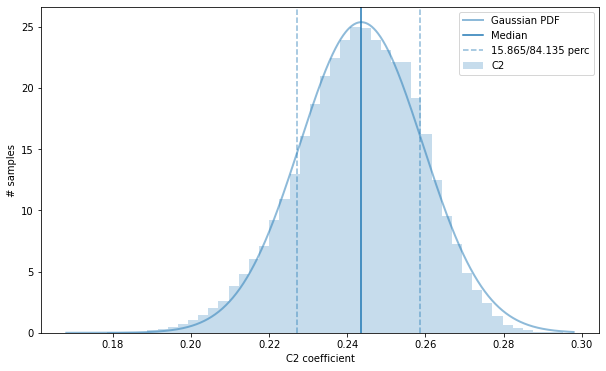

Median:   0.2435924891338279 +- 0.015735017584131764


In [35]:
print('number of samples:',len(c2_dist_logg),'  shape of the array:', c2_dist_logg.shape)

print()

c2_logg_average = np.average(c2_dist_logg) # average
c2_logg_median = np.median(c2_dist_logg)   # median
c2_logg_std = np.std(c2_dist_logg)         # standard deviation
c2_logg_minus1sigma_perc = np.percentile(c2_dist_logg, 15.865)
c2_logg_plus1sigma_perc = np.percentile(c2_dist_logg, 84.135)

# plt.hist will make an histogram, but it only accepts 1D arrays
# third output is something we don't need, so we use _
plt.figure(figsize=(10,6))
count, bins, _ = plt.hist(c2_dist_logg, 50, density=True, label='C2', alpha=0.25, color='C0')

x_gauss = np.linspace(bins[0], bins[-1], 1000)
y_gauss = 1/( c2_logg_std * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - c2_logg_median)**2 / (2 *  c2_logg_std**2) )
plt.plot(x_gauss, y_gauss, linewidth=2, label='Gaussian PDF',  color='C0', alpha=0.5)


plt.axvline(c2_logg_median,  c='C0', label='Median')
plt.axvline(c2_logg_minus1sigma_perc, alpha=0.5, c='C0', linestyle='--', label='15.865/84.135 perc')
plt.axvline(c2_logg_plus1sigma_perc , alpha=0.5, c='C0', linestyle='--')




plt.xlabel('C2 coefficient')
plt.ylabel('# samples')
plt.legend()
plt.show()


print("Median:  ", c2_logg_median, "+-", c2_logg_std)

